<a href="https://colab.research.google.com/github/doeungim/ADP/blob/master/ADP_28_F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from IPython.display import display , HTML
display(HTML("<style>.container {width :95% !important;}</style>"))

from scipy.stats import chi2_contingency
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE


from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score , classification_report

import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier


import time
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from scipy.stats import mannwhitneyu
import pingouin as pg

In [3]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p1.csv")
display(df.head())
display(df.info())

,sex,age,pstatus,medu,fedu,guardian,traveltime,studytime,failures,freetime,famrel,absences
0,F,18,A,4,4,mother,2,2,0,3,4,2
1,F,17,T,1,1,father,1,2,0,3,5,1
2,F,15,T,1,1,mother,1,2,3,3,4,3
3,F,15,T,4,2,mother,1,3,0,2,3,0
4,F,16,T,3,3,father,1,2,0,3,4,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sex         395 non-null    object
 1   age         395 non-null    int64 
 2   pstatus     395 non-null    object
 3   medu        395 non-null    int64 
 4   fedu        395 non-null    int64 
 5   guardian    395 non-null    object
 6   traveltime  395 non-null    int64 
 7   studytime   395 non-null    int64 
 8   failures    395 non-null    int64 
 9   freetime    395 non-null    int64 
 10  famrel      395 non-null    int64 
 11  absences    395 non-null    int64 
dtypes: int64(9), object(3)
memory usage: 37.2+ KB


None

<Figure size 640x480 with 0 Axes>

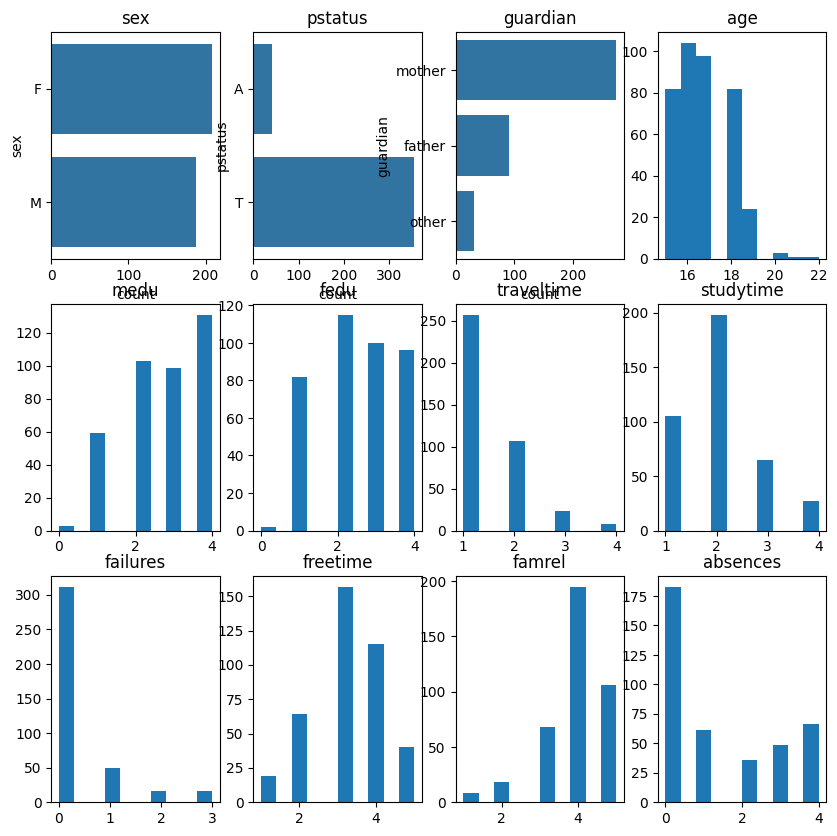

In [4]:
def make_plot(df) :
  plt.figure(figsize = (10 , 10))

  for i, col in enumerate(df.select_dtypes(include ='object').columns, start = 1):
    plt.subplot(3,4,i)
    plt.title(f'{col}')
    sns.countplot(df[col])
    start_num = i + 1

  for i, col in enumerate(df.select_dtypes(exclude = 'object').columns, start = start_num):
    plt.subplot(3,4,i)
    plt.title(f'{col}')
    plt.hist(df[col])

plt.tight_layout()
plt.show()

make_plot(df)



In [5]:
df1 = df.copy()


dummy_df = pd.get_dummies(df1, drop_first = True , dtype ='int')
dummy_df
s_df = MinMaxScaler().fit_transform(dummy_df)

df2 = pd.DataFrame(s_df, columns = dummy_df.columns)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13
var,0.266735,0.241753,0.165486,0.135356,0.087926,0.070169,0.066952,0.054688,0.049842,0.045145,0.038797,0.025635,0.023004
var_ratio,0.209782,0.190134,0.130152,0.106455,0.069152,0.055187,0.052656,0.043011,0.039200,0.035506,0.030513,0.020161,0.018092
cumsum,0.209782,0.399916,0.530068,0.636523,0.705675,0.760862,0.813518,0.856529,0.895728,0.931234,0.961747,0.981908,1.000000


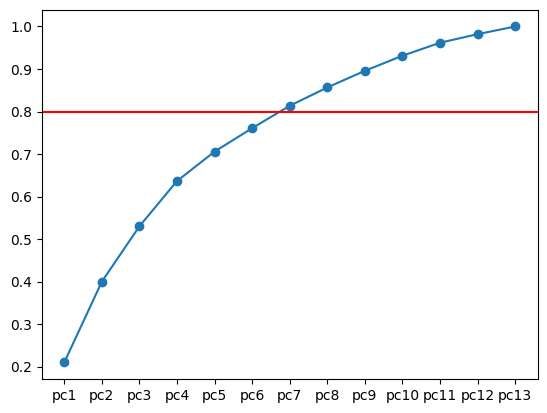

In [6]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df2)

pca_table = pd.DataFrame({'var' :pca.explained_variance_ ,
              'var_ratio': pca.explained_variance_ratio_})

pca_table.index = ['pc' + str(i + 1) for i in range(len(pca_table.index))]
pca_table['cumsum'] = pca_table['var_ratio'].cumsum()
display(pca_table.T)

plt.plot(pca_table['cumsum'],'o-')
plt.axhline(y = 0.80, color ='r', linestyle ='-')
plt.show()

<Axes: xlabel='absences', ylabel='count'>

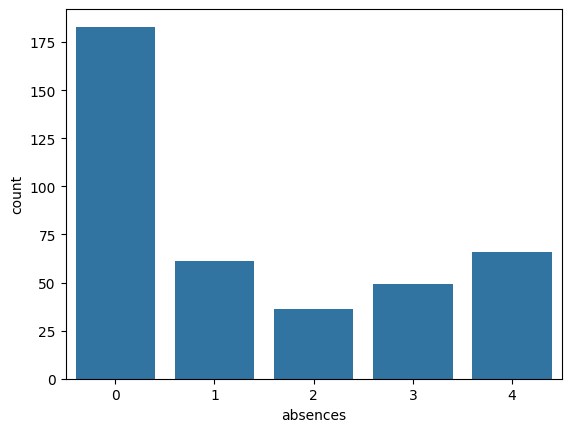

In [7]:
X = dummy_df.drop(columns = 'absences', axis =1)
y = dummy_df['absences']

## y의 확인 - 데이터 불균형
sns.countplot(x = dummy_df['absences'], data = dummy_df)

In [8]:
## SMOTE  - OverSampling : 소수의 레이블을 지닌 데이터 세트를 다수 레이블 만큼 증식
# 오버 샘플링 방식으로, 소수 레이블을 지닌 데이터 세트의 관착 값에 대한 K 개의 최근 이웃을 찾고,
# 임의의 새로운 데이터를 생성하는 방법이다.

from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state = 1)
x_re, y_re = smote.fit_resample(X, y)

print(Counter(y_re))

before = y.value_counts().to_frame('before').sort_index()
after = y_re.value_counts().to_frame('after').sort_index()

pd.concat([before, after], axis = 1).T



Counter({2: 183, 1: 183, 3: 183, 0: 183, 4: 183})


absences,0,1,2,3,4
before,183,61,36,49,66
after,183,183,183,183,183


In [9]:
rf = RandomForestClassifier(random_state = 1)
nn = MLPClassifier(random_state = 1)
gbm = LGBMClassifier(random_state = 1, verbose = -1)

x_train, x_test, y_train, y_test = train_test_split(x_re, y_re, test_size = 0.3, random_state = 1)

rf.fit(x_train, y_train)
nn.fit(x_train, y_train)
gbm.fit(x_train, y_train)


rf_pred = rf.predict(x_test)
nn_pred = nn.predict(x_test)
gbm_pred = gbm.predict(x_test)

from sklearn.metrics import f1_score

def f1_fitler(y_test, y_pred, name):
  macro = f1_score(y_test, y_pred, average ='macro')
  micro = f1_score(y_test, y_pred, average ='micro')
  weighted = f1_score(y_test, y_pred, average ='weighted')

  return pd.DataFrame([macro, micro, weighted], columns = [name], index = ['macro','micro','weighted'])

rf_f1 = f1_fitler(y_test, rf_pred, 'RandomForest')
nn_f1 = f1_fitler(y_test, nn_pred, 'Neural Net')
gbm_f1 = f1_fitler(y_test, gbm_pred, 'LightGBM')

pd.concat([rf_f1, nn_f1, gbm_f1], axis =1)

,RandomForest,Neural Net,LightGBM
macro,0.670943,0.388749,0.658260
micro,0.683636,0.400000,0.658182
weighted,0.670581,0.386624,0.657838


2-2. hard voting, soft voting에 대한 장단점을 설명하고 2-1의 3가지 모델로 구현하라. 두 방식의 f1-score를 비교하라 (10점)

In [10]:
rfv = RandomForestClassifier(random_state = 1)
nnv = MLPClassifier(random_state = 1)
gbmv = LGBMClassifier(random_state = 1, verbose = -1)



soft_v = VotingClassifier(estimators = [('rf', rfv), ('nn', nnv), ('gmb', gbmv)], voting = 'soft')
hard_v = VotingClassifier(estimators = [('rf', rfv), ('nn', nnv), ('gmb', gbmv)], voting = 'hard')

soft_v.fit(x_train, y_train)
hard_v.fit(x_train, y_train)

soft_pred = soft_v.predict(x_test)
hard_pred = hard_v.predict(x_test)


def f1_filter(y_test, y_pred, name) :
  macro = f1_score(y_test, y_pred, average = 'macro')
  micro = f1_score(y_test, y_pred, average = 'micro')
  weighted = f1_score(y_test, y_pred, average = 'weighted')

  return pd.DataFrame([macro, micro, weighted],  columns =[name] , index = ['macro','micro','weighted'])

soft_df = f1_filter(y_test, soft_pred, 'soft')
hard_df = f1_filter(y_test, hard_pred, 'hard')

pd.concat([soft_df, hard_df], axis = 1)

,soft,hard
macro,0.683596,0.693112
micro,0.683636,0.690909
weighted,0.683303,0.692831


Kaplan-Meier : 특정 기간 동안 사건이 발생하지 않고, 생존하는 개체의 비율을 추정하는 통계

- 생존 함수 : 특정 시간 이후까지 생존할 확률
- 위험 함수 : 특정 시간 이후까지 사건이 발생할 확률
- 센서링 : 사건이 발생하지 않았거나, 사망 원인이 명확하지 않은 경우

Kaplan-Meier 방법
- 비모수 적 방법, 정규 분포를 따르지 않아도 됨
- 여러 그룹간 생존율을 비교 할 수 있으며, 센서링을 고려할 수 있음

Kaplan_Meier 방법 관련 용어
- 생존 곡선 : 시간에 따른 생존율 그래프
- 위험 곡선 : 시간에 따른 위험 함수
- Log_Rank 검정 : 두 그룹간의 생존율 차이를 비교하는 통계 검정


In [11]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p4_.csv')


# statsu 0,1 변경
df['status_map'] = df['status'].map({'event lost': 0 , 'death': 1})


x = df[df.company == 'X'].reset_index(drop = True)
y = df[df.company == 'Y'].reset_index(drop = True)

kmf_x = KaplanMeierFitter()
kmf_x.fit(x[x.columns[0]], event_observed= x['status_map'])
x_pred = kmf_x.predict([25,35,45])


kmf_y = KaplanMeierFitter()
kmf_y.fit(y[y.columns[0]], event_observed = y['status_map'])
y_pred = kmf_y.predict([25,35,45])

두 회사간 생존시간 차이를 log-rank 방식으로 검정하시오. 가설설정, 통계량, 귀무가설 기각여부 판단(10점)

In [12]:
 # 귀무 가설 : 두 회간 생존 시간의 차이는 없다.
 # 대립 가설 : 두 회사간 생존 시간의 차이는 있다.

result = logrank_test(x[x.columns[0]],  y[y.columns[0]], \
                        event_observed_A = x['status_map'], \
                        event_observed_B = y['status_map']
                        )

display(result.summary)


,test_statistic,p,-log2(p)
0,0.2,0.654721,0.611048


시식여부가 구매의사에 영향을 주는지 가설을 설정

맥니마 : 치료 방법을 비교하거나, 전후 상황을 비교하는데 사용

- HO: 변수 A의 결과가 변수 B의 결과에 영향을 미치지 않는다.
- H1: 변수 A의 결과가 변수 B의 결과에 영향을 미친다. </br>

McNemar 검정은 일반적으로 반복 측정 또는 매칭된 샘플에 대한 분석에 사용되며, 두 가지 처리나 조건 간의 차이를 확인하는 데 유용

In [13]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p5_.csv')
df.head()

,data,userId
0,시식전_유__시식후_유,user_1
1,시식전_유__시식후_유,user_2
2,시식전_유__시식후_유,user_3
3,시식전_유__시식후_유,user_4
4,시식전_유__시식후_유,user_5


In [25]:
df['시식전'] = df['data'].str.split('__').str[0].str.split('_').str[1].map({'유':'구매함','무':'구매안함'})

df['before'] = df['data'].str.split('_').str[1].map({'유':'구매', '무': '구매안함'})
df['after'] = df['data'].str.split('__').str[1].str.split('_').str[1].map({'유':'구매', '무': '구매안함'})

r = pd.crosstab(df['before'], df['after'])
result= mcnemar(r)
print(result.pvalue)
print(result.statistic)

0.10775214433670044
8.0


6-1 A,B 지역 학생의 점수에 차이가 있는지 가설을 설정하고 정하시오 (10점)

In [42]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p6.csv')
display(df.head(3))

display(df.school_name.value_counts())

A = df.loc[df.school_name == 'A', 'score'].dropna()
B = df.loc[df.school_name == 'B', 'score'].dropna()

# NA를 제거하고 각 그룹별 Row의 갯수가 다를때 --- 만휘트니
print(len(A), len(B))

s, p = mannwhitneyu(A, B)
print(s, p)

,score,school_name,ID
0,91.0,A,1
1,NaN,A,2
2,NaN,A,3


school_name
A    18
B    18
Name: count, dtype: int64

10 18
58.0 0.13048990112711467


7-1 몸무게를 제어한다고 생각하고, 나이와 콜레스테롤 상관계수 및 유의확률 구하라(10점) </br>

- 편상관관계수의 정의 : 다른 독립 변수를 "통제"한 상태에서 두 변수간의 상관관계를 분석
- 예) "나이"가 동일한 상태에서 "특정 질병 발병 여부"와 "연봉"간의 상관계수를 측정한다.
- import pingouin as pg - pg.partial_corr

In [59]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p7.csv')

print(df.columns)
result = pg.partial_corr(data = df, x = 'Cholesterol', y = 'age', covar = 'weight')
print(result)
print(result[result.columns[-1]].values)

Index(['age', 'Cholesterol', 'weight'], dtype='object')
           n         r           CI95%     p-val
pearson  333 -0.134317  [-0.24, -0.03]  0.014316
[0.01431558]
